# Figure 10

In [1]:
using DataDeps, DelimitedFiles, LinearAlgebra, Plots, Plots.Measures, Random, Statistics
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2667 v2 @ 3.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, ivybridge)


## Load data and add noise

Register and download `DataDep`.

Chlorine data is given in cl2fullLarge.dat. Format is:
```
s1(t1) s2(t1) ...
s1(t2) s2(t2) ...
...
s1(tN) s2(tN) ...
```
Namely, each row has sensor measurements at one time.

In [2]:
register(DataDep(
    "chlorine",
    """
    Dataset: EPANET Chlorine Data Set
    Website: http://www.cs.cmu.edu/afs/cs/project/spirit-1/www/
    
    This data set contains chlorine data generated by EPANET, courtesy of Jeanne M. VanBriesen.
    """,
    "http://www.cs.cmu.edu/afs/cs/project/spirit-1/www/data/cl2fullLarge.zip",
    "dd4e938a8f9abd53800c89f1aebd8f8bfc3b5d848d1a96852320cfc0a3f552de",
    post_fetch_method=unpack
))
#;

In [3]:
data = readdlm(datadep"chlorine/cl2fullLarge.dat",' ',Float64,'\n') |> X->X.-mean(X,dims=1)
#;

Add heterogeneous noise

In [4]:
Random.seed!(5)

p, n = size(data)
noisydata = data + randn(p,n)*Diagonal([fill(sqrt(0.05),n÷2); fill(sqrt(0.2),n÷2)])
#;

## One-day window of a few cleaner and a few noisier sensors

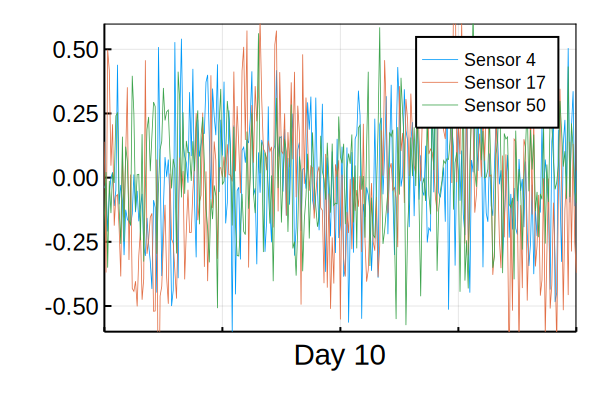

In [5]:
SENSORIDX1 = [4,17,50]

plot(size=(300,200),dpi=200,xticks=(10:0.25:11,""),xlims=(10,11),xlabel="Day 10",legend=:topright,
    legendfontsize=6,guidefontsize=10,framestyle=:box,
    ylims=(-0.6,0.6),yticks=-0.5:0.25:0.5)
for (t,s) in enumerate(SENSORIDX1)
    plot!(5/60/24*(0:size(noisydata,1)-1),noisydata[:,s],label="Sensor $s",
        linewidth=0.4,linecolor=palette(:default)[t])
end
plot!()

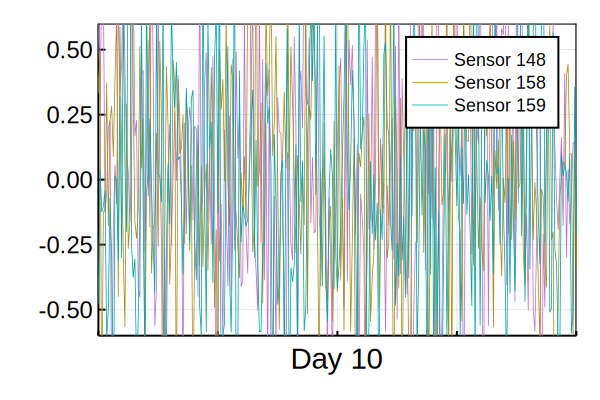

In [6]:
SENSORIDX2 = [148,158,159]

plot(size=(300,200),dpi=200,xticks=(10:0.25:11,""),xlims=(10,11),xlabel="Day 10",legend=:topright,
    legendfontsize=6,guidefontsize=10,framestyle=:box,
    ylims=(-0.6,0.6),yticks=-0.5:0.25:0.5)
for (t,s) in enumerate(SENSORIDX2)
    plot!(5/60/24*(0:size(noisydata,1)-1),noisydata[:,s],label="Sensor $s",
        linewidth=0.4,linecolor=palette(:default)[t+3])
end
plot!()

## One-day window of first four principal components

In [7]:
cdata = noisydata |> X->X.-mean(X,dims=2)

U = svd(cdata).U
#;

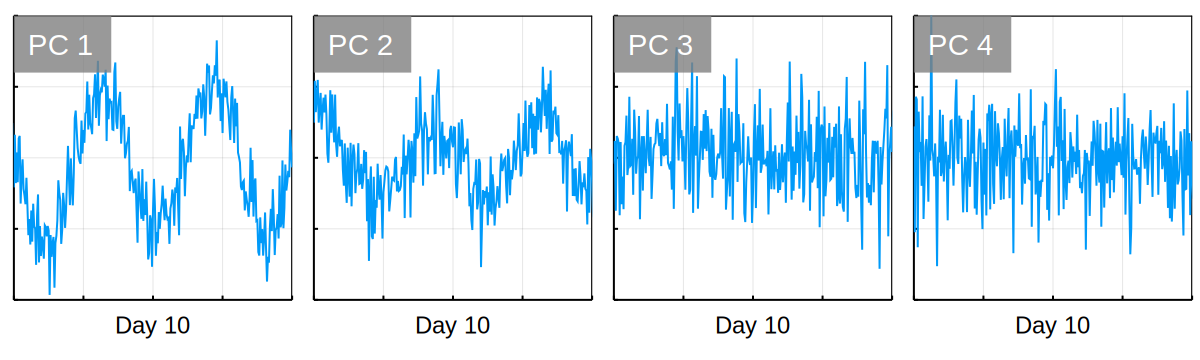

In [8]:
plts = map(1:4) do k
    plot(5/60/24*(0:size(noisydata,1)-1),normalize(U[:,k],Inf),label="",
        xticks=(10:0.25:11,""),xlims=(10,11),
        xlabel="Day 10",guidefontsize=8,
        ylims=(-1,1), yticks=(-1:0.5:1,""),
        framestyle=:box,right_margin=-1mm,left_margin=-2mm,top_margin=0mm)
    plot!(Shape([(10,0.6),(10.35,0.6),(10.35,1),(10,1)]),fillcolor=:gray,linewidth=0,label="",opacity=0.8)
    annotate!(10.05,0.8,text("PC $k",10,:left,:white))
end
plot(plts...,layout=(1,4),size=(600,180),dpi=200)

## Scree plots and empirical spectral distributions

In [9]:
Random.seed!(5)

cdata = noisydata |> X->X.-mean(X,dims=2)

fcdata = cdata .* rand([-1,1],size(cdata))
pcdata = mapslices(shuffle,cdata,dims=2)

σc  = svdvals(cdata)
σfc = svdvals(fcdata)
σpc = svdvals(pcdata)
#;

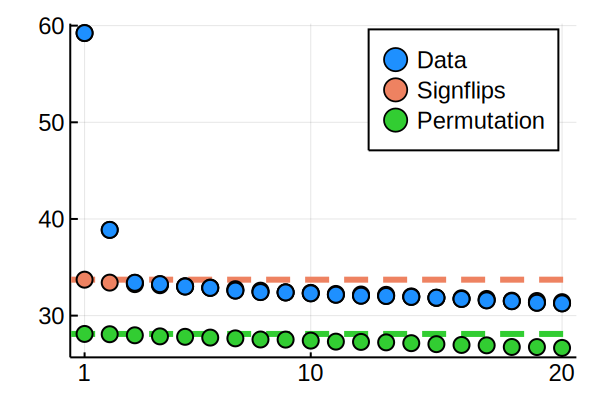

In [10]:
plot(size=(300,200),dpi=200,xticks=[1, 10, 20])
scatter!(σc[1:20],label="Data",color=:dodgerblue)

hline!([σfc[1]],linewidth=3,linestyle=:dash,label="",color=:salmon2)
scatter!(σfc[1:20],label="Signflips",color=:salmon2)

hline!([σpc[1]],linewidth=3,linestyle=:dash,label="",color=:limegreen)
scatter!(σpc[1:20],label="Permutation",color=:limegreen)

scatter!(σc[1:20],label="",color=:dodgerblue)

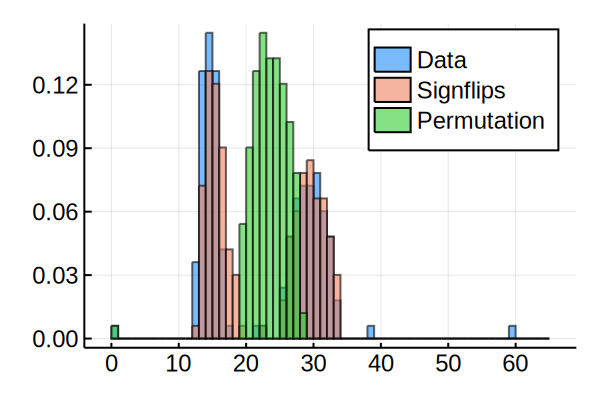

In [11]:
plot(size=(300,200),dpi=200)
histogram!( σc,bins=0:65,opacity=0.6,normalize=:pdf,label="Data",color=:dodgerblue)
histogram!(σfc,bins=0:65,opacity=0.6,normalize=:pdf,label="Signflips",color=:salmon2)
histogram!(σpc,bins=0:65,opacity=0.6,normalize=:pdf,label="Permutation",color=:limegreen)